In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [77]:
# Imports, nothing exciting here!

import pandas as pd
from tqdm import tqdm_notebook
import torch
import torch.nn
import torch.nn.functional as F
import sys

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from sith import SITH

# You might need to install seaborn if you haven't already
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

cuda


**GOAL: Learn to predict what letter is coming next given the context of the entire set of letters that came before it.**

Instead of using a buffer of the last few letters to predict what letter might be occuring next, I setup this example to use SITH. SITH has the ability to sparcify the entire history of letters presented to the model, which allows the subsequent layers to see all of the past at the same time, without having to greatly increase the size of the model. 

The example stimulus we will be using is the speach about the Sith Lord Darth Plagueis the Wise from Star Wars Episode 3. Individual letters will be presented to the model, one at a time, and the model will have to generate a prediction of what letter should occur next via a log probability. The letter assigned the highest probability is the one that the model has chosen to occur next.  

This notebook is broken up into a few sections. The first is a data pre-processing section where we clean the entire speach and break tokenize it for input to the model. The second is a cell where we test the parameters to be passed into our SITH layer. Selecting the parameters in sith_params will change where the centers of the temporal receptive fields inside SITH will be located, as well as how small the receptive fields are. The third section goes over how we add a SITH layer to a model, and train a model. The last section has a proof of concept cell where every letter is presented to the model, one at a time, and then the most highly predicted letter is printed out to the screen. If this is a readable quotation, then we know the model was able to train. We also included graphs of the loss through time. 


# Initialize "Corpus"

Setup the corpus, tokenize the input, and create a list of the target letters

In [87]:
# Define what goes at the end of a sentence, and what comes in the middle of 
# sentences
sentence_enders = ["?", ".", "!"]
separators = ["\'", ","]

# These are all of the tokens included in the stimuli that our model will be 
# seeing
letters = list("abcdefghijklmnopqrstuvwxyz".upper()) + ["<COM>", "<END>", "<SPA>"]

# create letter ids for the tokenizer function later
let_to_id = {s:x for x,s in enumerate(letters)}
# create a lookup table for model verification later
id_to_let = dict([[v,k] for k,v in let_to_id.items()])

# Read in the entire text
full_text = open("plagueis.txt", "r").read()

# Make them all captical letters, and remove ellipsis. Add space before each 
# sentence ender and sentence separator
full_text = full_text.upper()
full_text = full_text.replace("...", ".")
full_text = full_text.replace(".", " .")
full_text = full_text.replace("?", " ?")
full_text = full_text.replace(",", " ,")
full_test = full_text.replace("\'", " \'")

# split into individual words
split_text = full_text.split()

master_list = []
id_list = []

# Generate list of letter id's to be turned into 1-hot vectors by a 
# tokenizing function. The letter A has the id 0. The letter Z is 25. etc. 
for s in split_text:
    # loop over each letter in each word
    for l in s:
        if l in sentence_enders:
            master_list.append("<END>")
            id_list.append(let_to_id["<END>"])
        elif l in separators:
            master_list.append("<COM>")
            id_list.append(let_to_id["<COM>"])
        else:
            master_list.append(l)
            id_list.append(let_to_id[l])
    # add a space after each word and after each sentence modifier
    master_list.append("<SPA>")
    id_list.append(let_to_id["<SPA>"])

# tokenizing funciton, turns each letter into 
def tokenize(inp_list, num_tokens=10):
    output = torch.zeros(len(inp_list), num_tokens, 1).type(torch.DoubleTensor)
    for i, inp in enumerate(inp_list):
        output[i, inp, 0] = 1.0
    return output

# create a variable, tokens, that can be batched and used later for training and testing.
input_tokens = tokenize(id_list[:-1], len(list(let_to_id.keys())))
target_tokens = torch.DoubleTensor(id_list[1:]).view(-1, 1, 1)
if torch.cuda.is_available():
    input_tokens = input_tokens.cuda()
    target_tokens = target_tokens.cuda()

tokens = torch.cat((input_tokens, target_tokens), 1)



# Test the SITH parameters

Here, you can pick parameters to be used further down in the model. The parameters for a sith layer are as follows:

    Parameters
    ----------
        in_features: int
            Number of tracked features
        tau_0: float (default = 1)
            The center of the first receptive field in inverse-Lapace space. The
            presentation time of each stimulus.
        dt: float (default=.1)
            The input will be presented to the representation at tau_0 / dt seconds.
            This will smooth the exponential decay, and provide a better estimate of 
            the past in the final inverse-laplace representation.
        k: int (default = 4)
            The spcificity of the receptive fields
        c: float
            The degree of historical compression. Smaller numbers means greater
            numbers of tau*s will be dedicated to tracking the more recent past
        alpha: float
        g: float (default = 0)
            A conditionditioning parameter. This will determine if the end result 
            of this layer, big T, is multiplied by tau_stars or not.  If g is 0, 
            then big T will have smaller and smaller activations further into the 
            past. If g = 1, then all taustars in big T will activate to the same 
            level at their peak. g can also be bigger than 1, but should never be 
            less than 0. 
        ntau: int (default = 100)
            The desired number of taustars in the final representation, before
            indexing with T_every
        T_every: int
            How many tau*s we skip when indexing into the inverse-laplace space
            representation, T.

This cell will print out a variable called *taustars*. This variable contains the centers of the receptive fields that will be in the output of this layer. When utilizing a SITH layer, pick parameters that give you taustar locations that extend far enough into the past that all relavent information for doing the task will be contained within the SITH representation.  

For instance, if you think that there is useful information for your model contained in the inputs that happened 100 inputs into the past, then you need to make sure that your taustars at least go to 100, if not further out. 

Below, we have a sith-rep setup such that it can track every single letter, and the 3 additional symbol tokens, for more that 761 inputs. But instead of tracking the exact order of these 761+ inputs, we follow weiner vecner scaling laws in our compression turning 761 time points into a log compressed representation with 18 taustars. These taustars have high temporal specificity for the early taustars, and more sparce temporal specificity for the later taustars. 

Changing tau_0 changes where the first taustar will be located in time.

Increasing K will increase the temporal specificity of all taustars, but high values of K combined with low values of c will cause numerical errors.

c changes the difference between taustars. Lowever values of c will have much closer together taustars. 

ntau is the total number of taustars that will be tracked and generated by the model. This number is much larger than the number of taustars that will be outputed to the next layer of your model, however. A lot of them are very redundent, so we index into all of the taustars by skipping every T_every positions. 

dt should be a significantly small number compared to tau_0. It helps with the smoothness of the internal numerical components of the layer.

In [88]:
sith_params ={"in_features":len(list(let_to_id.keys())),
              "tau_0":1, "k":4,
              "c":.05, "ntau":140, "dt":.1, 
              "T_every":8, "alpha":1.0}
# This is only for making sure you pick the right parameters
sithrep = SITH(**sith_params)
sithrep.cuda()
taustars = sithrep._tau_star[sith_params['k']:-sith_params['k']:sith_params['T_every']].detach().cpu().numpy()

print(taustars)

[  1.           1.47745544   2.18287459   3.22509994   4.76494147
   7.03998871  10.40126965  15.36741246  22.7046672   33.54513415
  49.56144107  73.22482091 108.18641027 159.8406008  236.15736578
 348.91198567 515.50191263 761.63110709]


# Define the model

It is a simple model that takes in single tokens as input, and generates a prediction of the token that should occur next. 

The input tensor should be of size (batch, num_tokens) as input, as SITH is able to handle batched input. The output of this layer is a tensor of size (batch, num_tokens\*num_taustars) because we flatten the output to prepare it for the next layer. The second layer of the model is just a fully connected hidden layer to the output, of size (len(taustars)\*num_tokens, num_tokens). The output is of size (batch, num_tokens), and is passed through a log_softmax function.

The output tensor of this model will assign the highest log proability to the token that is most likely to occur next. 

In [105]:
class LetterModel(torch.nn.Module):
    def __init__(self, sith_params, num_tokens, torch_type="double", sith_cuda=True):
        super(LetterModel, self).__init__()
        self.sith = SITH(**sith_params)
        if sith_cuda:
            self.sith.cuda()
        num_taustars = self.sith._tau_star[sith_params['k']:-sith_params['k']:sith_params['T_every']].shape[0]
        if torch_type == "double":
            self.linear = torch.nn.Linear(num_tokens*num_taustars, num_tokens).double()
        elif torch_type == "float":
            self.linear = torch.nn.Linear(num_tokens*num_taustars, num_tokens).float()
    def reset(self):
        self.sith.reset()

        
    def forward(self, inputs):
        batch_size = inputs.shape[0]
        x = F.relu(self.sith(inputs)).view(batch_size, -1)
        x = self.linear(x)
        log_probs = F.log_softmax(x, dim=-1)
        return log_probs


# Define and Train the Model

In [127]:
model = LetterModel(sith_params, len(list(let_to_id.keys()))).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
loss_func = torch.nn.NLLLoss()
input_scaling = 10

In [128]:
epochs = 1000
progress_bar = tqdm_notebook(range(int(epochs)))
loss_track = {"val":[], "epoch":[], "batch_num":[], "last_correct":[]}
acc = 0
for e in progress_bar:
    model.reset()
    c = 0
    for inp_and_tok in tokens.split(20, dim=0):
        inps = inp_and_tok[:, :-1, 0]
        targets = inp_and_tok[:, -1, 0].type(torch.cuda.LongTensor)
        model.zero_grad()
        out = model(inps*input_scaling)
        loss = loss_func(out, targets)
        loss.backward()
        loss_track['val'].append(loss.mean().detach().cpu().numpy())
        loss_track['epoch'].append(e)
        loss_track['batch_num'].append(c)
        loss_track['last_correct'].append(acc)
        optimizer.step()
        c += 1
    model.reset()
    t = 0
    correct = 0
    pp = 0
    for inp_and_tok in tokens.split(20, dim=0):
        inps = inp_and_tok[:, :-1, 0]
        targets = inp_and_tok[:, -1, 0].type(torch.cuda.LongTensor)
        out = model(inps*input_scaling)

        # Accuracy
        correct += (out.argmax(-1) == targets).sum().detach().cpu().numpy()
        t += inps.shape[0]

    acc = correct/t
    progress_bar.set_description("%i: Acc: %0.4f" % (e, acc))

A Jupyter Widget

In [129]:
loss_track = pd.DataFrame(loss_track)

Text(0.5,1,'Correct Acc over Batches')

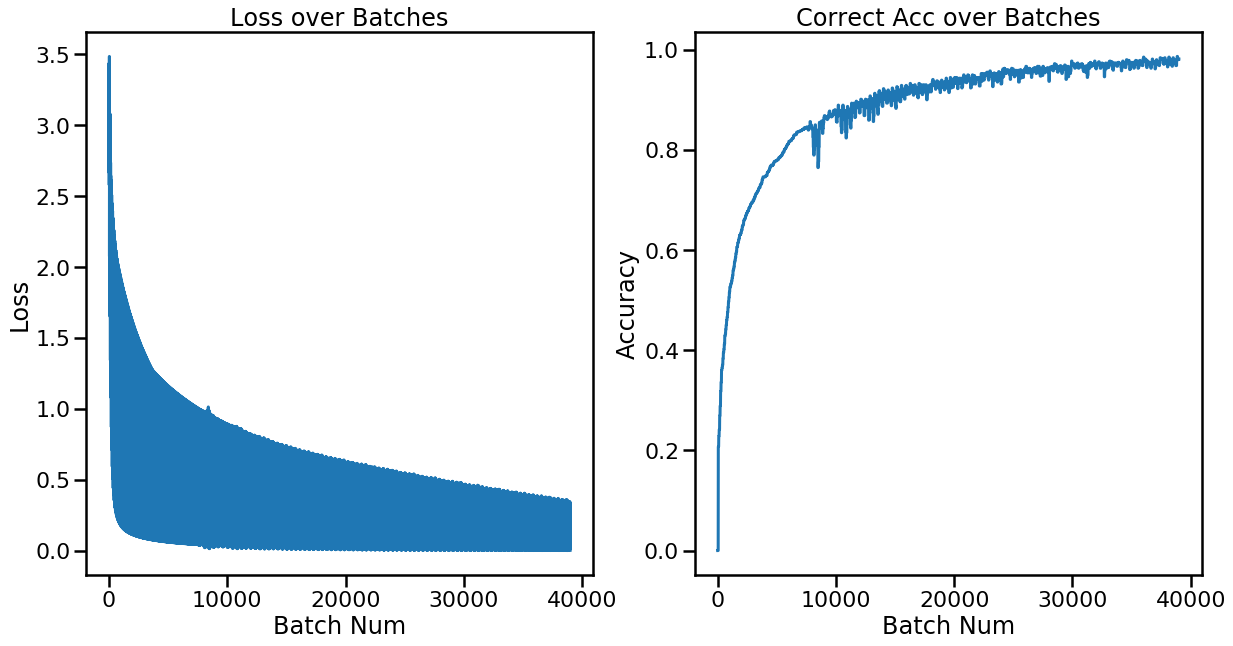

In [130]:
fig = figure(figsize=(20, 10))

ax = fig.add_subplot(1,2,1)
ax.plot(loss_track['val'])
ax.set_xlabel("Batch Num")
ax.set_ylabel("Loss")
ax.set_title("Loss over Batches")
ax = fig.add_subplot(1,2,2)
ax.plot(loss_track['last_correct'])
ax.set_xlabel("Batch Num")
ax.set_ylabel("Accuracy")
ax.set_title("Correct Acc over Batches")


# Test the finished model

Prints out the most likely letter to occur when taking in the last letter as input. This cell is just a proof of concept that the model is working at all. 

In [131]:
model.reset()
t = 0
correct = 0
pp = 0
for inp_and_tok in tokens.split(20, dim=0):
    inps = inp_and_tok[:, :-1, 0]
    targets = inp_and_tok[:, -1, 0].type(torch.cuda.LongTensor)
    out = model(inps*input_scaling)

    # Accuracy
    indexes = out.argmax(-1).detach().cpu().numpy()
    for i in indexes:
        sys.stdout.write(id_to_let[i])


ID<SPA>YOU<SPA>EVER<SPA>HEARET<SPA><SPA><SPA>TRAGEDY<SPA>OF<SPA>DARTH<SPA>PLAGUEIS<SPA>THE<SPA>WISE<SPA><END><SPA>I<SPA>THOUGHT<SPA>NOT<SPA><END><SPA>IT<COM>S<SPA>NOT<SPA><SPA><SPA>STTRY<SPA>THE<SPA>JEDI<SPA>WOULD<SPA>TELL<SPA>YOU<SPA><END><SPA>IT<COM>S<SPA>A<SPA>SITH<SPA>LEGEND<SPA><END><SPA>DARTH<SPA>PLAGUEIS<SPA>WAS<SPA>A<SPA>DARK<SPA>LORD<SPA>OF<SPA>THE<SPA>SISH<SPA><COM><SPA>SO<SPA>POWERFUL<SPA>AND<SPA>SO<SPA>WISE<SPA>HE<SPA>COULD<SPA>USE<SPA>THE<SPA>FORCE<SPA>TO<SPA>INFLUENCE<SPA>THE<SPA>MIDICHLORIANS<SPA>TO<SPA>CREATE<SPA>LIFE<SPA><END>EHE<SPA>HAD<SPA>SUCH<SPA>A<SPA>KNOWLEDGE<SPA>OF<SPA>THE<SPA>DARK<SPA>SIDE<SPA>THAT<SPA>HE<SPA>COULD<SPA>EVEN<SPA>KEEP<SPA>THE<SPA>ONES<SPA>HE<SPA>CARED<SPA>ABOUT<SPA>FROM<SPA>DYING<SPA><END><SPA>THE<SPA>DARK<SPA>SIDE<SPA>OF<SPA>THE<SPA>FORCE<SPA>IS<SPA>A<SPA>PATHWAY<SPA>TO<SPA>MANY<SPA>ABILITIESSSOME<SPA>CONSIDER<SPA>TO<SPA>BE<SPA>UNNATURAL<SPA><END><SPA>HE<SPA>BECAME<SPA>SO<SPA>POWERFUL<SPA><END><SPA>THE<SPA>ONLY<SPA>THING<SPA>HE<SPA>WAS<SPA>AFRA